In [1]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.10  # Set to 10% for 4.8 GB out of 48 GB
config.gpu_options.allow_growth = True

session = InteractiveSession(config=config)

2024-02-14 19:43:44.538317: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-14 19:43:45.048464: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-14 19:43:45.048513: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-14 19:43:45.049836: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-14 19:43:45.058756: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# import tensorflow as tf

# print("TensorFlow version:", tf.__version__)

# # Check for available GPUs
# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#     print("Available GPUs:")
#     for gpu in gpus:
#         print(gpu)
# else:
#     print("No GPUs detected.")


In [3]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
import numpy as np

In [4]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Plant_leave_diseases_dataset_without_augmentation",
    shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE 
    
)

Found 55448 files belonging to 39 classes.


2024-02-14 19:43:58.711488: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4867 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:3b:00.0, compute capability: 8.6
2024-02-14 19:43:58.926728: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


In [6]:
class_names = dataset.class_names
class_names

['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy',
 'Background_without_leaves',
 'Blueberry___healthy',
 'Cherry___Powdery_mildew',
 'Cherry___healthy',
 'Corn___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn___Common_rust',
 'Corn___Northern_Leaf_Blight',
 'Corn___healthy',
 'Grape___Black_rot',
 'Grape___Esca_(Black_Measles)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___healthy',
 'Orange___Haunglongbing_(Citrus_greening)',
 'Peach___Bacterial_spot',
 'Peach___healthy',
 'Pepper,_bell___Bacterial_spot',
 'Pepper,_bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Raspberry___healthy',
 'Soybean___healthy',
 'Squash___Powdery_mildew',
 'Strawberry___Leaf_scorch',
 'Strawberry___healthy',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot'

In [7]:
len(dataset)

1733

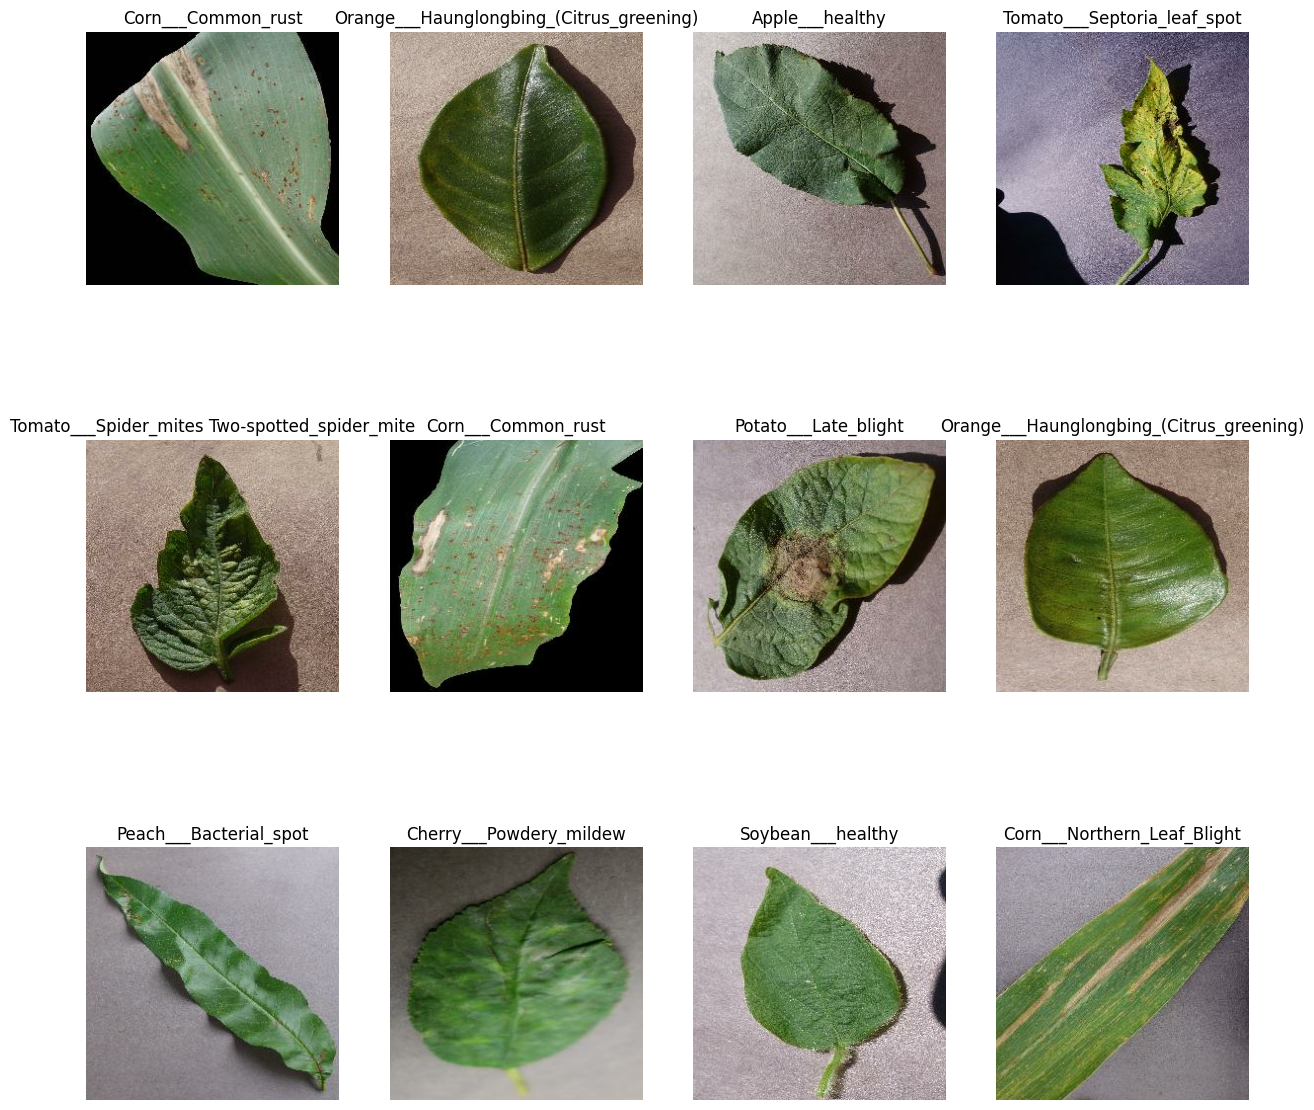

In [8]:
plt.figure(figsize =(15,15)) #It will increase the area

for image_batch,label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [9]:
len(dataset)

1733

In [10]:
1733*32 #68 batches and one batch contains 32 images so total is 2176 images actual images are 2152

55456

In [11]:
# 80% ==>training
# 20% ==> 10% validation, 10%test

In [12]:
train_size = 0.8
len(dataset)*train_size

1386.4

In [13]:
train_ds = dataset.take(1386)
len(train_ds)

1386

In [14]:
test_ds = dataset.skip(1386)
len(test_ds)

347

In [15]:
val_size=0.1
len(dataset)*val_size

173.3

In [16]:
val_ds = test_ds.take(173)
len(val_ds)

173

In [17]:
test_ds = test_ds.skip(173)
len(test_ds)

174

In [18]:
def get_dataset_partitions_tf(ds, train_split = 0.8,val_split = 0.1,test_split=0.1,shuffle=True,shuffle_size = 10000):
    
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
        
    train_size = int(train_split * ds_size)
    val_size = int(val_split*ds_size)

    train_ds = ds.take(train_size)
    
    val_ds =  ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds,val_ds,test_ds
    

In [19]:
train_ds,val_ds,test_ds = get_dataset_partitions_tf(dataset)

In [20]:
len(train_ds)

1386

In [21]:
len(val_ds)

173

In [22]:
len(test_ds)

174

In [23]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds   = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds  = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [24]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255),
    
])

In [25]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [26]:
input_shape = (BATCH_SIZE, IMAGE_SIZE,IMAGE_SIZE, CHANNELS)
n_classes = 39

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    
    layers.Conv2D(32, (3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64, kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Flatten(),
    layers.Dense(64,activation = 'relu'),
    
    layers.Dense(n_classes,activation='softmax'),

])

model.build(input_shape = input_shape)
    

In [27]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [28]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy']
)

history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size  = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

In [29]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/50


2024-02-14 19:44:17.268919: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:13: Filling up shuffle buffer (this may take a while): 76 of 10000
2024-02-14 19:44:27.270821: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:13: Filling up shuffle buffer (this may take a while): 150 of 10000
2024-02-14 19:44:47.207590: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:13: Filling up shuffle buffer (this may take a while): 298 of 10000
2024-02-14 19:44:57.253196: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:13: Filling up shuffle buffer (this may take a while): 373 of 10000
2024-02-14 19:45:17.108803: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:13: Filling up shuffle buffer (this may take a while): 516 of 10000
2024-02-14 19:45:27.110658: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:13: Filling up shuffle buffer (this may tak

1385/1386 [============================>.] - ETA: 0s - loss: 2.3650 - accuracy: 0.3528

2024-02-14 19:49:06.478998: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:13: Filling up shuffle buffer (this may take a while): 1469 of 10000
2024-02-14 19:49:08.120907: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.
2024-02-14 19:49:08.125009: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


1386/1386 [==============================] - 306s 45ms/step - loss: 2.3646 - accuracy: 0.3529 - val_loss: 1.6973 - val_accuracy: 0.5341
Epoch 2/50
1386/1386 [==============================] - 49s 35ms/step - loss: 1.1126 - accuracy: 0.6665 - val_loss: 0.8517 - val_accuracy: 0.7439
Epoch 3/50
1386/1386 [==============================] - 49s 35ms/step - loss: 0.6834 - accuracy: 0.7856 - val_loss: 0.6268 - val_accuracy: 0.7903
Epoch 4/50
1386/1386 [==============================] - 49s 35ms/step - loss: 0.5085 - accuracy: 0.8368 - val_loss: 0.4330 - val_accuracy: 0.8604
Epoch 5/50
1386/1386 [==============================] - 48s 35ms/step - loss: 0.4283 - accuracy: 0.8615 - val_loss: 0.4398 - val_accuracy: 0.8568
Epoch 6/50
1386/1386 [==============================] - 51s 37ms/step - loss: 0.3603 - accuracy: 0.8817 - val_loss: 0.3925 - val_accuracy: 0.8678
Epoch 7/50
1386/1386 [==============================] - 50s 36ms/step - loss: 0.3241 - accuracy: 0.8938 - val_loss: 0.2932 - val_accur

In [30]:
scores = model.evaluate(test_ds)

2024-02-14 20:29:43.075414: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:13: Filling up shuffle buffer (this may take a while): 85 of 10000
2024-02-14 20:29:53.150178: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:13: Filling up shuffle buffer (this may take a while): 176 of 10000
2024-02-14 20:30:03.171115: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:13: Filling up shuffle buffer (this may take a while): 257 of 10000
2024-02-14 20:30:23.110136: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:13: Filling up shuffle buffer (this may take a while): 427 of 10000
2024-02-14 20:30:33.206634: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:13: Filling up shuffle buffer (this may take a while): 509 of 10000
2024-02-14 20:30:53.227057: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:13: Filling up shuffle buffer (this may tak

  5/174 [..............................] - ETA: 2s - loss: 0.1139 - accuracy: 0.9688      

2024-02-14 20:33:06.199585: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.
2024-02-14 20:33:06.204607: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


174/174 [==============================] - 216s 15ms/step - loss: 0.1275 - accuracy: 0.9605


In [31]:
scores

[0.12747812271118164, 0.960488498210907]

In [32]:
history

In [33]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 1386}

In [34]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

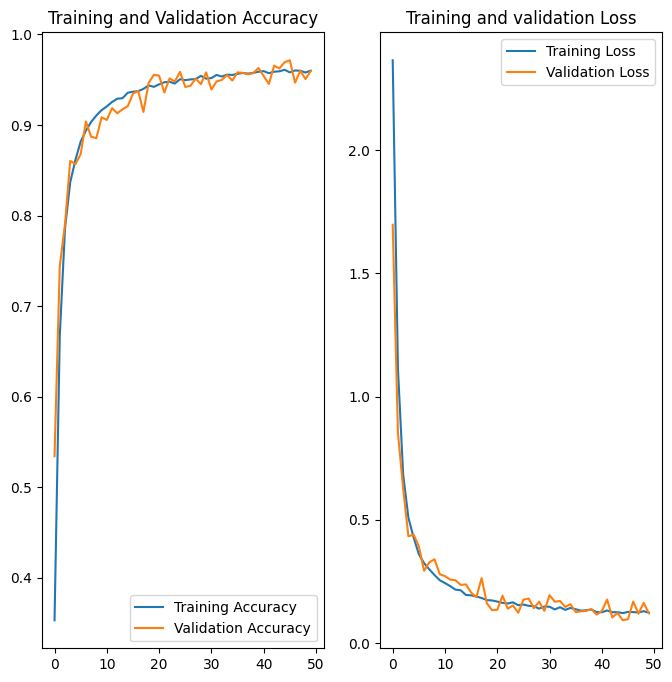

In [36]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,label='Training Loss')
plt.plot(range(EPOCHS),val_loss,label='Validation Loss')
plt.legend(loc= 'upper right')
plt.title('Training and validation Loss')
plt.show()

first image to predict
first image's actual label : Tomato___Tomato_Yellow_Leaf_Curl_Virus
1/1 [==============================] - 0s 143ms/step
Predicted label:  Tomato___Tomato_Yellow_Leaf_Curl_Virus


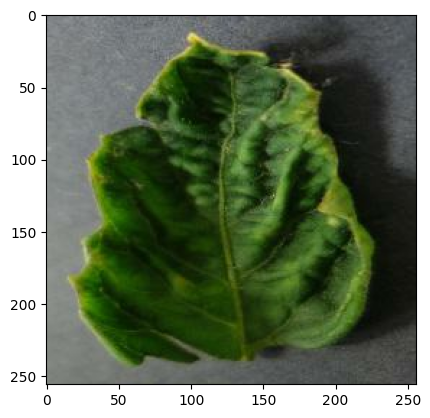

In [37]:
for images_batch, labels_batch in test_ds.take(1):
    # print(images_batch[0]) #tensor
    # print(images_batch[0].numpy()) #tensor to numpy
    #Display images
    # plt.imshow(images_batch[0].numpy().astype('uint8'))

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("first image's actual label :",class_names[first_label])

    batch_prediction =  model.predict(images_batch)
    print("Predicted label: ",class_names[np.argmax(batch_prediction[0])])

In [38]:
# def predict(model,img):
#     img_array = tf.keras.preprocessing.image.img_to_aray(images[i].numpy())
#     img_array = tf.expand_dims(img_array,0) #create a batch

#     predictions = model.predict(img_array)

#     predicted_class = class_names[np.argmax(predictions[0])]
#     confidence = round(100 * (np.max(predictions[0])),2)
#     return predicted_class, confidence





def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 25ms/step


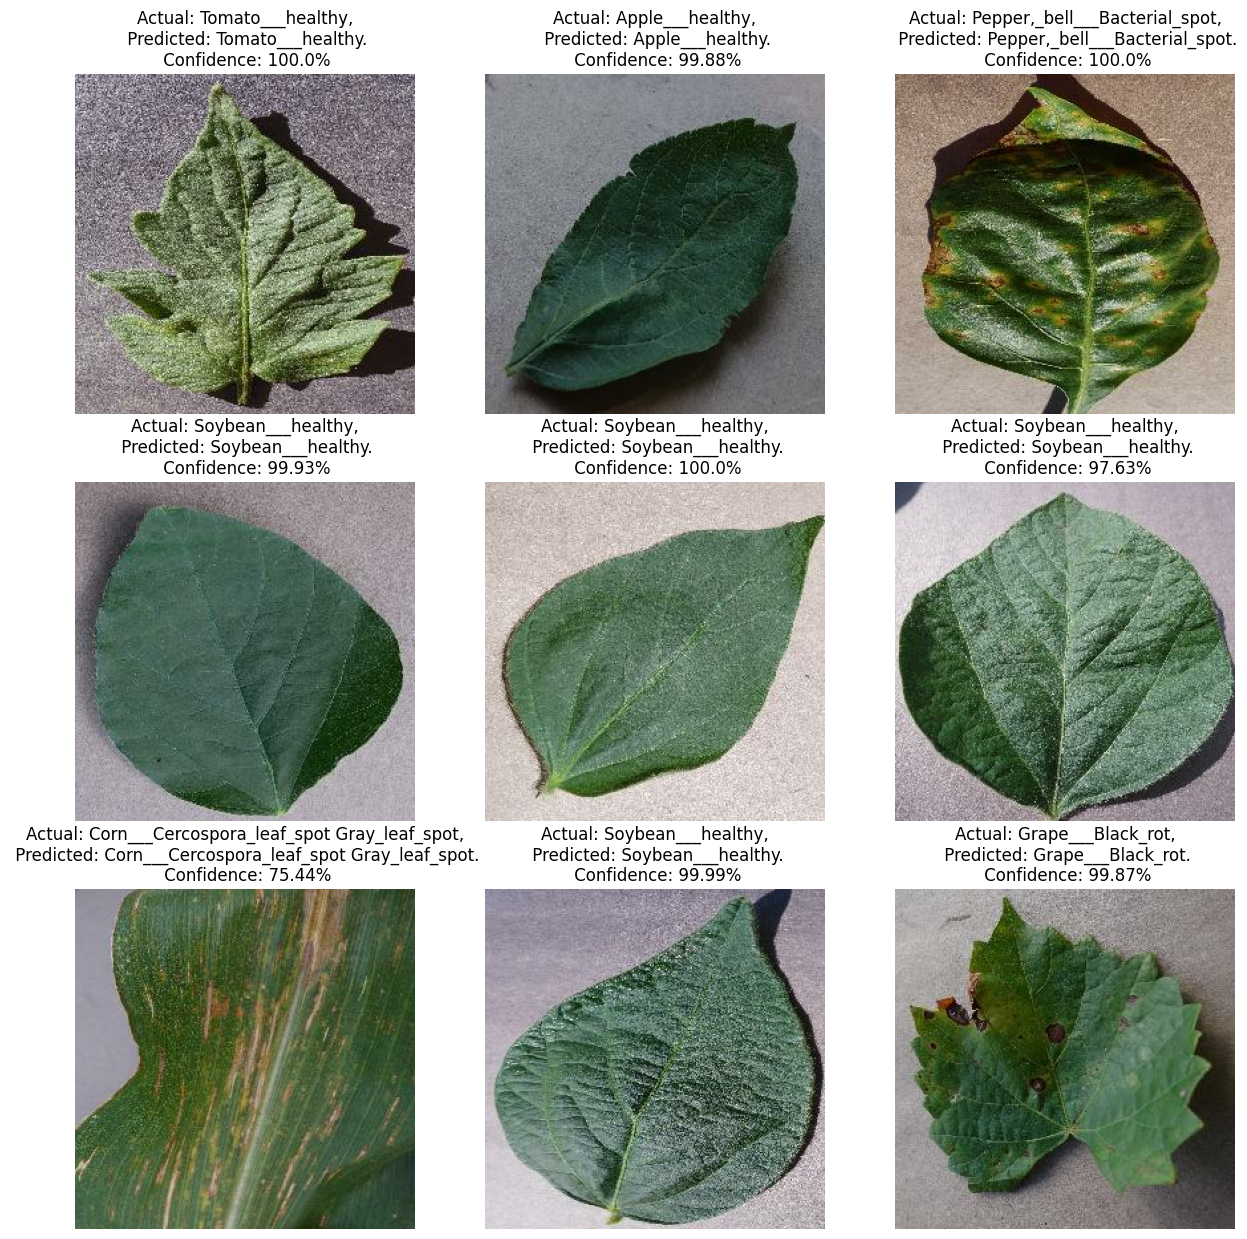

In [39]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax= plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model,images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")



In [40]:
# model.version=1
# model.save(f"../models/"{model_version})

In [42]:
import os
model_version = max([int(i) for i in os.listdir("models") + [0]]) + 1 #next model version
model.save(f"models/{model_version}")

INFO:tensorflow:Assets written to: models/1/assets


INFO:tensorflow:Assets written to: models/1/assets
